# ETL & DATA WRANGLING


We begin with extracting the data, transforming it to ML friendly formats and save it for our future machine learning model. After importing dependencies, we will have two methods to extract or read the data. In method 1 we incorporate pyspark module and its functions to read the data and visualize it. We will also create a temporarty view of the data to save memory while querying the data. This method is helpful when we deal with big data. In second method we directly use Pandas to read the data.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)

## *Reading data with Spark*

In [2]:
import findspark
findspark.init()
from pyspark import SparkFiles
from pyspark.sql import SparkSession

In [3]:
# spark = SparkSession.builder.appName("SalesForecasting").getOrCreate()

In [3]:
spark = SparkSession.builder.master("local[10]").config("spark.driver.memory", "10g").getOrCreate()

In [4]:
base_path =os.getcwd()
train_sp_df = spark.read.csv(SparkFiles.get(f"{base_path}\\Resources\\sales_train_evaluation.csv"), sep=",", header=True)
calendar_sp_df = spark.read.csv(SparkFiles.get(f"{base_path}\\Resources\\calendar.csv"), sep=",", header=True)
sell_prices_sp_df = spark.read.csv(SparkFiles.get(f"{base_path}\\Resources\\sell_prices.csv"), sep=",", header=True)

### Creating a temporary view for dataframes

In [5]:
train_sp_df.createOrReplaceTempView('train_data_set')

In [6]:
calendar_sp_df.createOrReplaceTempView('calendar')

In [7]:
sell_prices_sp_df.createOrReplaceTempView('sell_prices')

In [8]:
print(f"train_sp_df:  {train_sp_df.count()} rows & {len(train_sp_df.columns)}columns")
print(f"calendar_sp_df: {calendar_sp_df.count()} rows & {len(calendar_sp_df.columns)} columns")
print(f"sell_prices_sp_df:  {sell_prices_sp_df.count()} rows & {len(sell_prices_sp_df.columns)} columns")

train_sp_df:  30490 rows & 1947columns
calendar_sp_df: 1969 rows & 14 columns
sell_prices_sp_df:  6841121 rows & 4 columns


### Showing part of temp views

In [9]:
# Showing part of the train data set view
tds_partial_query = """
select id, item_id, dept_id, cat_id, store_id, state_id, d_1, d_2, d_3
from train_data_set
limit 10
"""
spark.sql(tds_partial_query).show()

+--------------------+-------------+---------+-------+--------+--------+---+---+---+
|                  id|      item_id|  dept_id| cat_id|store_id|state_id|d_1|d_2|d_3|
+--------------------+-------------+---------+-------+--------+--------+---+---+---+
|HOBBIES_1_001_CA_...|HOBBIES_1_001|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_002_CA_...|HOBBIES_1_002|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_003_CA_...|HOBBIES_1_003|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_004_CA_...|HOBBIES_1_004|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_005_CA_...|HOBBIES_1_005|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_006_CA_...|HOBBIES_1_006|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_007_CA_...|HOBBIES_1_007|HOBBIES_1|HOBBIES|    CA_1|      CA|  0|  0|  0|
|HOBBIES_1_008_CA_...|HOBBIES_1_008|HOBBIES_1|HOBBIES|    CA_1|      CA| 12| 15|  0|
|HOBBIES_1_009_CA_...|HOBBIES_1_009|HOBBIES_1|HOBBIES|    CA_1|  

In [10]:
# Query part of the calander view
cal_query = """
select * from calendar
limit 10
"""
spark.sql(cal_query).show()

+----------+--------+---------+----+-----+----+----+------------+------------+------------+------------+-------+-------+-------+
|      date|wm_yr_wk|  weekday|wday|month|year|   d|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|
+----------+--------+---------+----+-----+----+----+------------+------------+------------+------------+-------+-------+-------+
|2011-01-29|   11101| Saturday|   1|    1|2011| d_1|        NULL|        NULL|        NULL|        NULL|      0|      0|      0|
|2011-01-30|   11101|   Sunday|   2|    1|2011| d_2|        NULL|        NULL|        NULL|        NULL|      0|      0|      0|
|2011-01-31|   11101|   Monday|   3|    1|2011| d_3|        NULL|        NULL|        NULL|        NULL|      0|      0|      0|
|2011-02-01|   11101|  Tuesday|   4|    2|2011| d_4|        NULL|        NULL|        NULL|        NULL|      1|      1|      0|
|2011-02-02|   11101|Wednesday|   5|    2|2011| d_5|        NULL|        NULL|        NULL|      

In [11]:
# Query sell prices view
sp_query = """
select * from sell_prices
limit 10
"""
spark.sql(sp_query).show()

+--------+-------------+--------+----------+
|store_id|      item_id|wm_yr_wk|sell_price|
+--------+-------------+--------+----------+
|    CA_1|HOBBIES_1_001|   11325|      9.58|
|    CA_1|HOBBIES_1_001|   11326|      9.58|
|    CA_1|HOBBIES_1_001|   11327|      8.26|
|    CA_1|HOBBIES_1_001|   11328|      8.26|
|    CA_1|HOBBIES_1_001|   11329|      8.26|
|    CA_1|HOBBIES_1_001|   11330|      8.26|
|    CA_1|HOBBIES_1_001|   11331|      8.26|
|    CA_1|HOBBIES_1_001|   11332|      8.26|
|    CA_1|HOBBIES_1_001|   11333|      8.26|
|    CA_1|HOBBIES_1_001|   11334|      8.26|
+--------+-------------+--------+----------+



## Convertig views to pandas dataframe

In [12]:
tds_query = "select * from train_data_set limit 10"
train_df = spark.sql(tds_query)
train_df = train_df.toPandas()

In [13]:
c_query = "select * from calendar"
calendar_df = spark.sql(c_query)
calendar_df = calendar_df.toPandas()

In [14]:
sp_query = "select * from sell_prices"
sell_prices_df = spark.sql(sp_query)
sell_prices_df = sell_prices_df.toPandas()

In [15]:
display(train_df.head())
display(calendar_df.head())
display(sell_prices_df.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


### Reading data with pandas

In [2]:
train_df = pd.read_csv("Resources/sales_train_evaluation.csv")
calendar_df = pd.read_csv("Resources/calendar.csv")
sell_prices_df = pd.read_csv("Resources/sell_prices.csv")

# Preprocessing Data

We will attempt to forecast the daily sales of all 10 Walmart stores separately. To that end we separate the data set into 3 data frames, one for each of the states California, Texas and Wisconsin.

## *Separating States In Train Data Set*

In [3]:
ca_sales_df = train_df[train_df['state_id']=='CA'].copy()
print(f'Data frame for California has shape {ca_sales_df.shape} with {ca_sales_df.isna().sum().sum()} NA values')

Data frame for California has shape (12196, 1947) with 0 NA values


In [4]:
tx_sales_df = train_df[train_df['state_id']=='TX'].copy()
print(f'Data frame for Texas has shape {tx_sales_df} with {tx_sales_df.isna().sum().sum()} NA values')

Data frame for Texas has shape                                   id        item_id    dept_id   cat_id  \
12196  HOBBIES_1_001_TX_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
12197  HOBBIES_1_002_TX_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
12198  HOBBIES_1_003_TX_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
12199  HOBBIES_1_004_TX_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
12200  HOBBIES_1_005_TX_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
21338    FOODS_3_823_TX_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
21339    FOODS_3_824_TX_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
21340    FOODS_3_825_TX_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
21341    FOODS_3_826_TX_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
21342    FOODS_3_827_TX_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9

In [5]:
wi_sales_df = train_df[train_df['state_id']=='WI'].copy()
print(f'Data frame for Wisconsin has shape {wi_sales_df} with {wi_sales_df.isna().sum().sum()} NA values')

Data frame for Wisconsin has shape                                   id        item_id    dept_id   cat_id  \
21343  HOBBIES_1_001_WI_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
21344  HOBBIES_1_002_WI_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
21345  HOBBIES_1_003_WI_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
21346  HOBBIES_1_004_WI_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
21347  HOBBIES_1_005_WI_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8 

In [6]:
display(ca_sales_df.head())
display(tx_sales_df.head())
display(wi_sales_df.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
12196,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,0

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
21343,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,2,1,2,0,0,1,0,0,2,1,0,0,0,0,1,0,2,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1,2,0,2,3,0,0,0,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,2,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,1,0,1,0,0,1,0,0,2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1

# Separating States in Sell Prices Data Set

In [7]:
ca_sell_prices = sell_prices_df[sell_prices_df["store_id"].isin(["CA_1","CA_2","CA_3","CA_4"])]
print(f'Sell Pricess for California has shape {ca_sell_prices.shape} and {ca_sell_prices.isna().sum().sum()} NA values')
display(ca_sell_prices.head())

Sell Pricess for California has shape (2708822, 4) and 0 NA values


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
tx_sell_prices = sell_prices_df[sell_prices_df['store_id'].isin(['TX_1', 'TX_2', 'TX_3'])]
print(f'Sell Pricess for Texas has has shape {tx_sell_prices.shape} and {tx_sell_prices.isna().sum().sum()} NA values')
display(tx_sell_prices.head())

Sell Pricess for Texas has has shape (2092122, 4) and 0 NA values


,store_id,item_id,wm_yr_wk,sell_price
2708822,TX_1,HOBBIES_1_001,11325,9.58
2708823,TX_1,HOBBIES_1_001,11326,8.26
2708824,TX_1,HOBBIES_1_001,11327,8.26
2708825,TX_1,HOBBIES_1_001,11328,8.26
2708826,TX_1,HOBBIES_1_001,11329,8.26


In [9]:
wi_sell_prices = sell_prices_df[sell_prices_df['store_id'].isin(['WI_1','WI_2', 'WI_3'])]
print(f'Sell Pricess for Wisconsin has has shape {wi_sell_prices.shape} and {wi_sell_prices.isna().sum().sum()} NA values')
display(wi_sell_prices.head())

Sell Pricess for Wisconsin has has shape (2040177, 4) and 0 NA values


,store_id,item_id,wm_yr_wk,sell_price
4800944,WI_1,HOBBIES_1_001,11325,9.58
4800945,WI_1,HOBBIES_1_001,11326,9.58
4800946,WI_1,HOBBIES_1_001,11327,9.58
4800947,WI_1,HOBBIES_1_001,11328,9.58
4800948,WI_1,HOBBIES_1_001,11329,9.58


# Melting Sales Data Frame to join with other Data Frames

In [10]:
# Melting California DataFrame
ca_sales_df_melted = ca_sales_df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
ca_sales_df_melted.rename({"variable":"Day","value":"Quantity"},axis=1,inplace=True)
display(ca_sales_df_melted.head())

,id,item_id,dept_id,cat_id,store_id,state_id,Day,Quantity
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [11]:
# Melting Texas DataFrame
tx_sales_df_melted = tx_sales_df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
tx_sales_df_melted.rename({"variable":"Day","value":"Quantity"},axis=1,inplace=True)
display(tx_sales_df_melted.head())

,id,item_id,dept_id,cat_id,store_id,state_id,Day,Quantity
0,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0
1,HOBBIES_1_002_TX_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0
2,HOBBIES_1_003_TX_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0
3,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,d_1,1
4,HOBBIES_1_005_TX_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0


In [12]:
# Melting Wisconsin DataFrame
wi_sales_df_melted = wi_sales_df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
wi_sales_df_melted.rename({"variable":"Day","value":"Quantity"},axis=1,inplace=True)
display(wi_sales_df_melted.head())

,id,item_id,dept_id,cat_id,store_id,state_id,Day,Quantity
0,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0
1,HOBBIES_1_002_WI_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0
2,HOBBIES_1_003_WI_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0
3,HOBBIES_1_004_WI_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,WI_1,WI,d_1,2
4,HOBBIES_1_005_WI_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0


# Merging Data Frames

In [13]:
calendar_df.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [14]:
# Join for California
ca_joined_df = pd.merge(left=ca_sales_df_melted, right=calendar_df, how='left', left_on='Day', right_on='d')
ca_joined_df = pd.merge(left=ca_joined_df, right=sell_prices_df, how='left', on=["store_id","item_id","wm_yr_wk"])
ca_joined_df.drop(["snap_TX","snap_WI"],axis=1,inplace=True)
ca_joined_df['total_sales'] = ca_joined_df['Quantity'] * ca_joined_df['sell_price']
display(ca_joined_df.head())

,id,item_id,dept_id,cat_id,store_id,state_id,Day,Quantity,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,total_sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,NaN,NaN


In [15]:
# Join for Texas
tx_joined_df = pd.merge(left=tx_sales_df_melted, right=calendar_df, how='left', left_on='Day', right_on='d')
tx_joined_df = pd.merge(left=tx_joined_df, right=sell_prices_df, how='left', on=["store_id","item_id","wm_yr_wk"])
tx_joined_df.drop(["snap_CA","snap_WI"],axis=1,inplace=True)
tx_joined_df['total_sales'] = tx_joined_df['Quantity'] * tx_joined_df['sell_price']
# display(tx_joined_df.head())

In [16]:
# Join for Wisconsin
wi_joined_df = pd.merge(left=wi_sales_df_melted, right=calendar_df, how='left', left_on='Day', right_on='d')
wi_joined_df = pd.merge(left=wi_joined_df, right=sell_prices_df, how='left', on=["store_id","item_id","wm_yr_wk"])
wi_joined_df.drop(["snap_CA","snap_TX"],axis=1,inplace=True)
wi_joined_df['total_sales'] = wi_joined_df['Quantity'] * wi_joined_df['sell_price']
# display(wi_joined_df.head())

# Daily Total (Daily SUM) Sales Aggregation

In [17]:
# Groupby and pivot for California
ca_store_sales_sum = ca_joined_df.groupby(['store_id', 'date'], as_index=False).agg(Total_Sales=('total_sales', 'sum'))
ca_store_sales_sum['date'] = pd.to_datetime(ca_store_sales_sum['date'])
ca_store_sales_sum = ca_store_sales_sum.pivot(index="date",columns="store_id",values="Total_Sales")
display(ca_store_sales_sum.head())

store_id,CA_1,CA_2,CA_3,CA_4
date,,,,
2011-01-29,10933.16,9101.52,11679.83,4561.59
2011-01-30,9787.06,8417.53,12161.46,4681.41
2011-01-31,7201.38,5320.51,9123.86,3637.98
2011-02-01,7407.74,5550.56,10249.78,3708.92
2011-02-02,6566.12,5229.72,9538.65,3841.14


In [18]:
# Groupby and pivot for Texas
tx_store_sales_sum = tx_joined_df.groupby(['store_id', 'date'], as_index=False).agg(Total_Sales=('total_sales', 'sum'))
tx_store_sales_sum['date'] = pd.to_datetime(tx_store_sales_sum['date'])
tx_store_sales_sum = tx_store_sales_sum.pivot(index="date",columns="store_id",values="Total_Sales")
display(tx_store_sales_sum.head())

store_id,TX_1,TX_2,TX_3
date,,,
2011-01-29,6586.68,9915.78,7597.99
2011-01-30,6610.60,9804.54,7356.54
2011-01-31,4551.97,6651.16,5406.70
2011-02-01,5374.39,6985.60,5597.97
2011-02-02,4347.07,6039.05,4069.74


In [19]:
# Groupby and pivot for Wisconsin
wi_store_sales_sum = wi_joined_df.groupby(['store_id', 'date'], as_index=False).agg(Total_Sales=('total_sales', 'sum'))
wi_store_sales_sum['date'] = pd.to_datetime(wi_store_sales_sum['date'])
wi_store_sales_sum = wi_store_sales_sum.pivot(index="date",columns="store_id",values="Total_Sales")
display(wi_store_sales_sum.head())

store_id,WI_1,WI_2,WI_3
date,,,
2011-01-29,6454.72,5451.46,9367.88
2011-01-30,5645.77,4636.86,9868.80
2011-01-31,3640.12,4621.58,7551.65
2011-02-01,2949.96,5754.75,7181.53
2011-02-02,2.96,2679.19,4646.31


# Graphical Representation of datasets

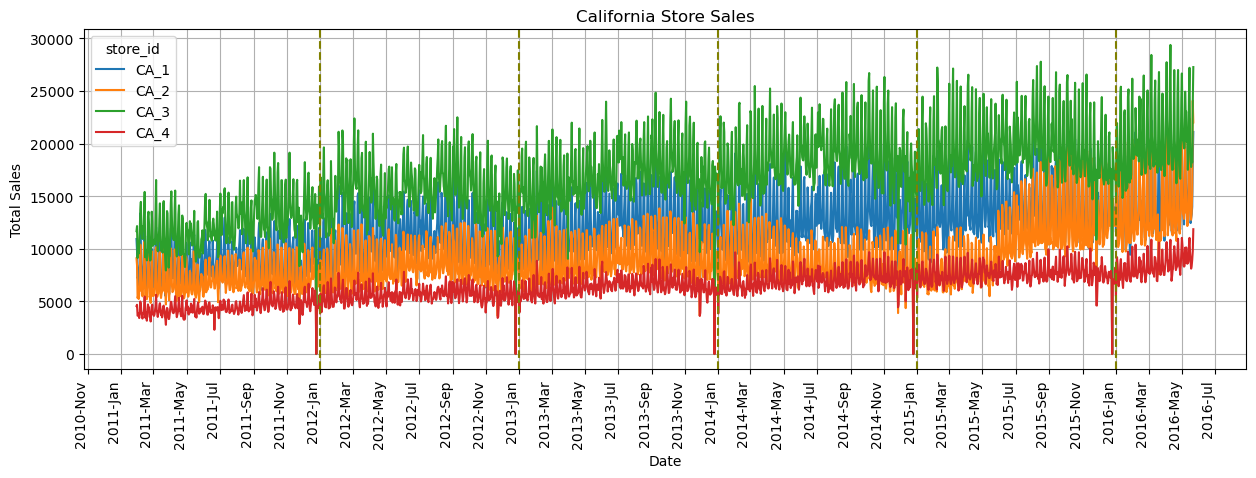

In [20]:
ca_store_sales_sum.plot(legend=True,
                        figsize=(15,5),
                        grid=True,
                        ylabel="Total Sales",
                        xlabel="Date",
                        x_compat=True,
                        title='California Store Sales')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for i in range(2,7):
    ax.axvline(f'01-01-201{i}', color='olive', ls='--')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

<Axes: title={'center': 'Mid Dec to Mid Jan Sales(California)'}, xlabel='Date', ylabel='Total Sales'>

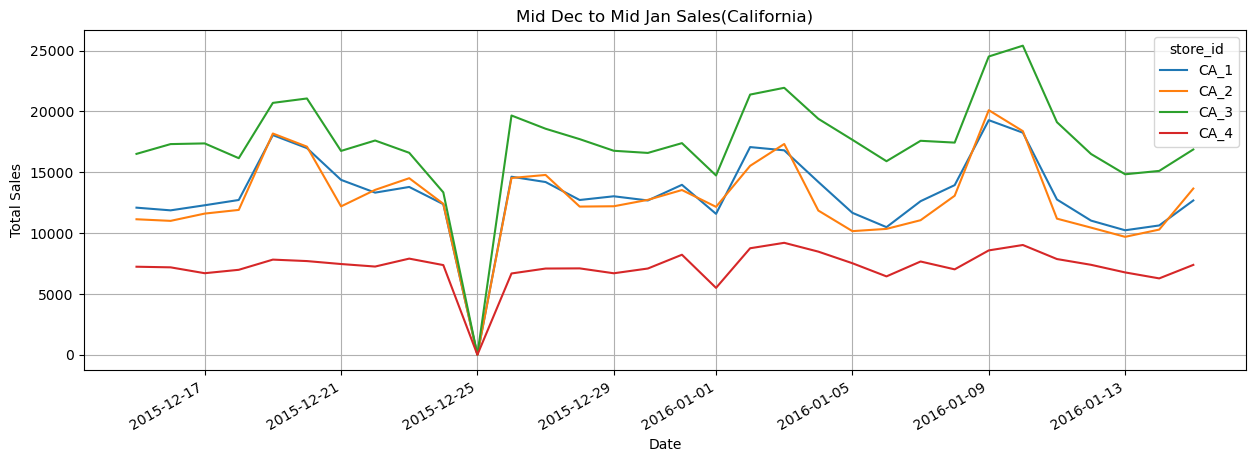

In [20]:
ca_store_sales_sum[(ca_store_sales_sum.index>='12-15-2015') &
                   (ca_store_sales_sum.index<='01-15-2016')].plot(legend=True,
                                                                  figsize=(15,5),
                                                                  grid=True,
                                                                  title = 'Mid Dec to Mid Jan Sales(California)',
                                                                  ylabel="Total Sales",
                                                                  xlabel="Date",
                                                                  x_compat=True)

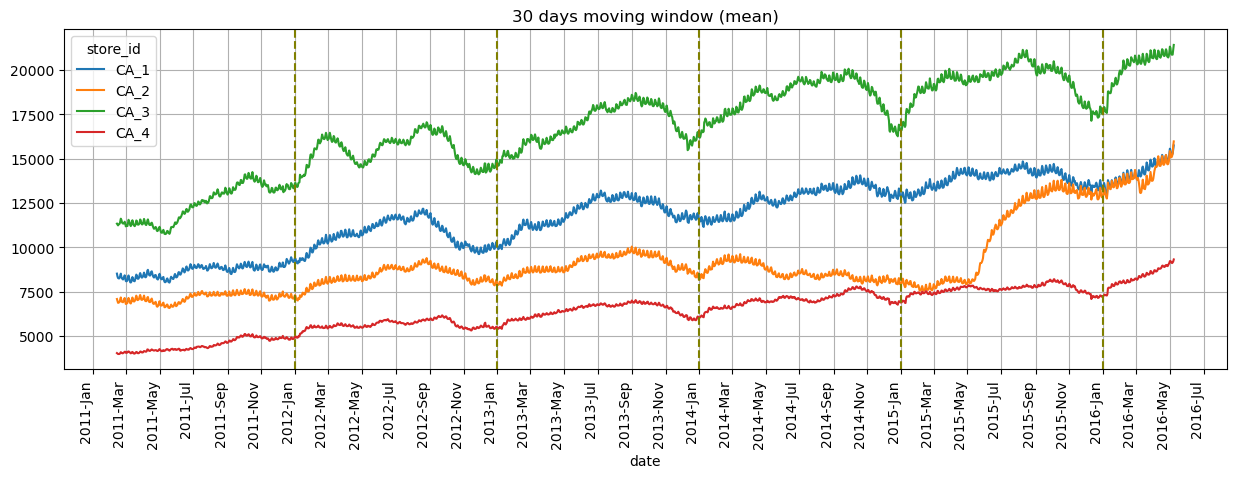

In [21]:
ca_store_sales_sum.rolling(30, center=True).mean().plot(figsize=(15,5), title='30 days moving window (mean) - California', 
                                                        fontsize=10, grid=True, x_compat=True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for i in range(2,7):
    ax.axvline(f'01-01-201{i}', color='olive', ls='--')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

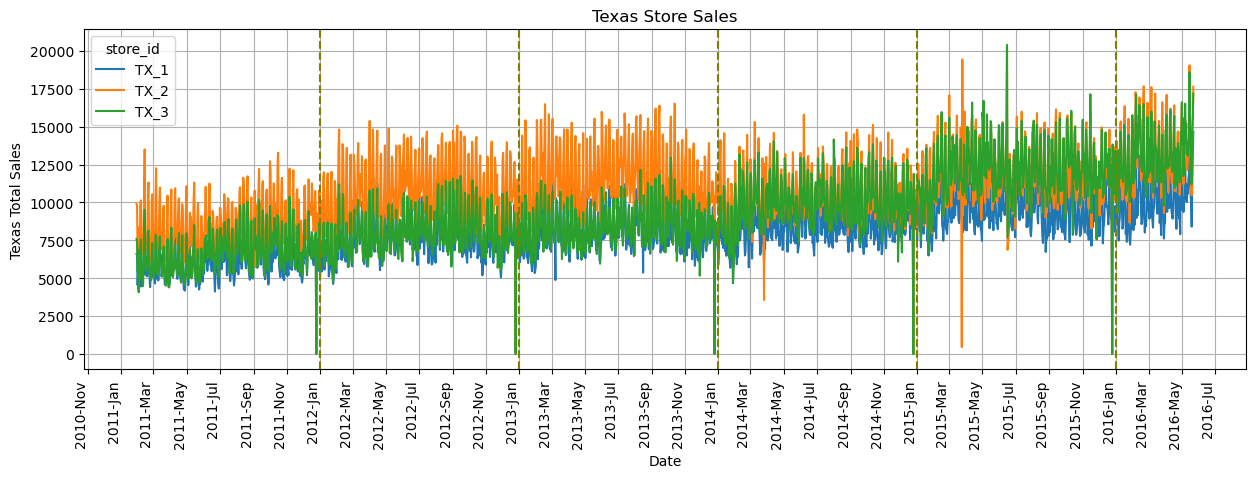

In [21]:
tx_store_sales_sum.plot(legend=True,
                        figsize=(15,5),
                        grid=True,
                        ylabel="Texas Total Sales",
                        xlabel="Date",
                        x_compat=True,
                        title='Texas Store Sales')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for i in range(2,7):
    ax.axvline(f'01-01-201{i}', color='olive', ls='--')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

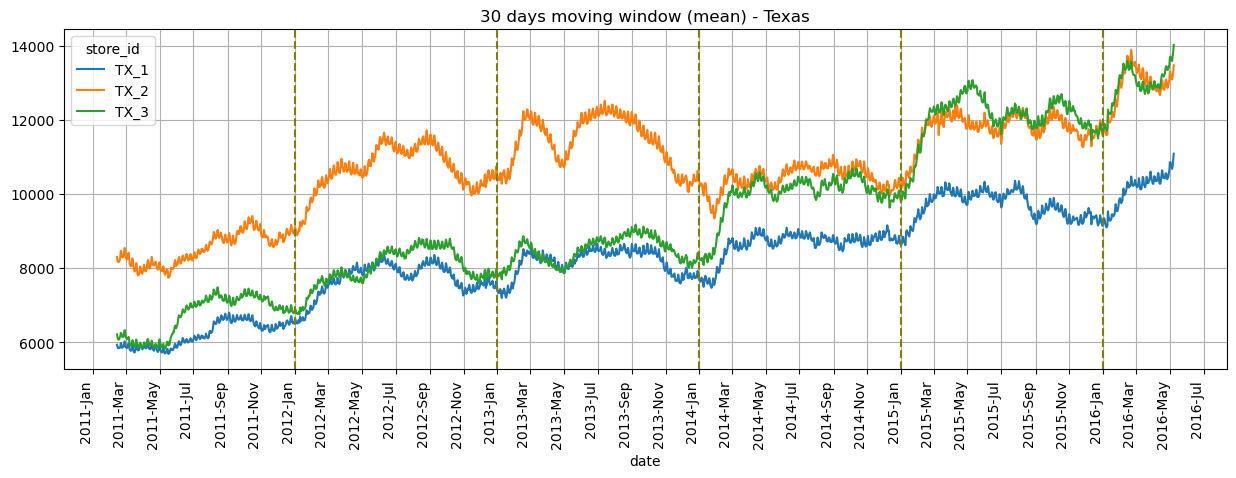

In [23]:
tx_store_sales_sum.rolling(30, center=True).mean().plot(figsize=(15,5), title='30 days moving window (mean) - Texas', 
                                                        fontsize=10, grid=True, x_compat=True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for i in range(2,7):
    ax.axvline(f'01-01-201{i}', color='olive', ls='--')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

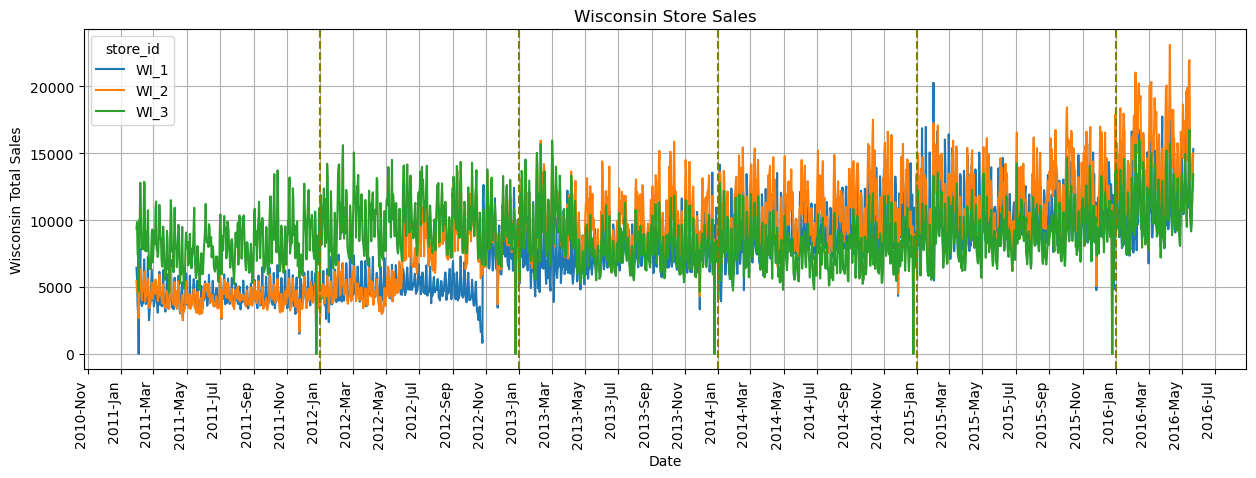

In [22]:
wi_store_sales_sum.plot(legend=True,
                        figsize=(15,5),
                        grid=True,
                        ylabel="Wisconsin Total Sales",
                        xlabel="Date",
                        x_compat=True,
                        title='Wisconsin Store Sales')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for i in range(2,7):
    ax.axvline(f'01-01-201{i}', color='olive', ls='--')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

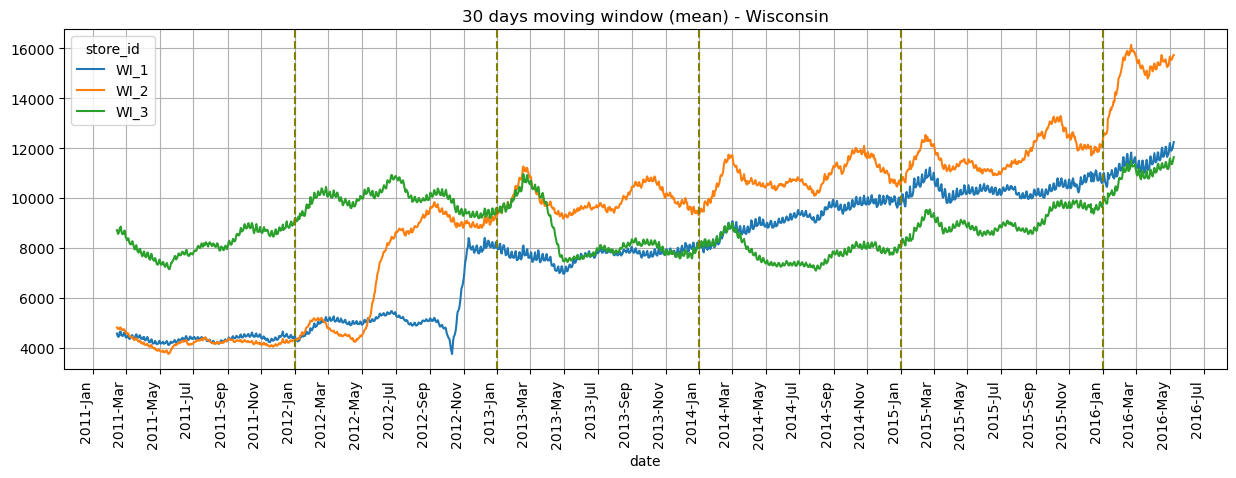

In [24]:
wi_store_sales_sum.rolling(30, center=True).mean().plot(figsize=(15,5), title='30 days moving window (mean) - Wisconsin', 
                                                        fontsize=10, grid=True, x_compat=True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for i in range(2,7):
    ax.axvline(f'01-01-201{i}', color='olive', ls='--')    
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Text(0.5, 0.98, 'California')

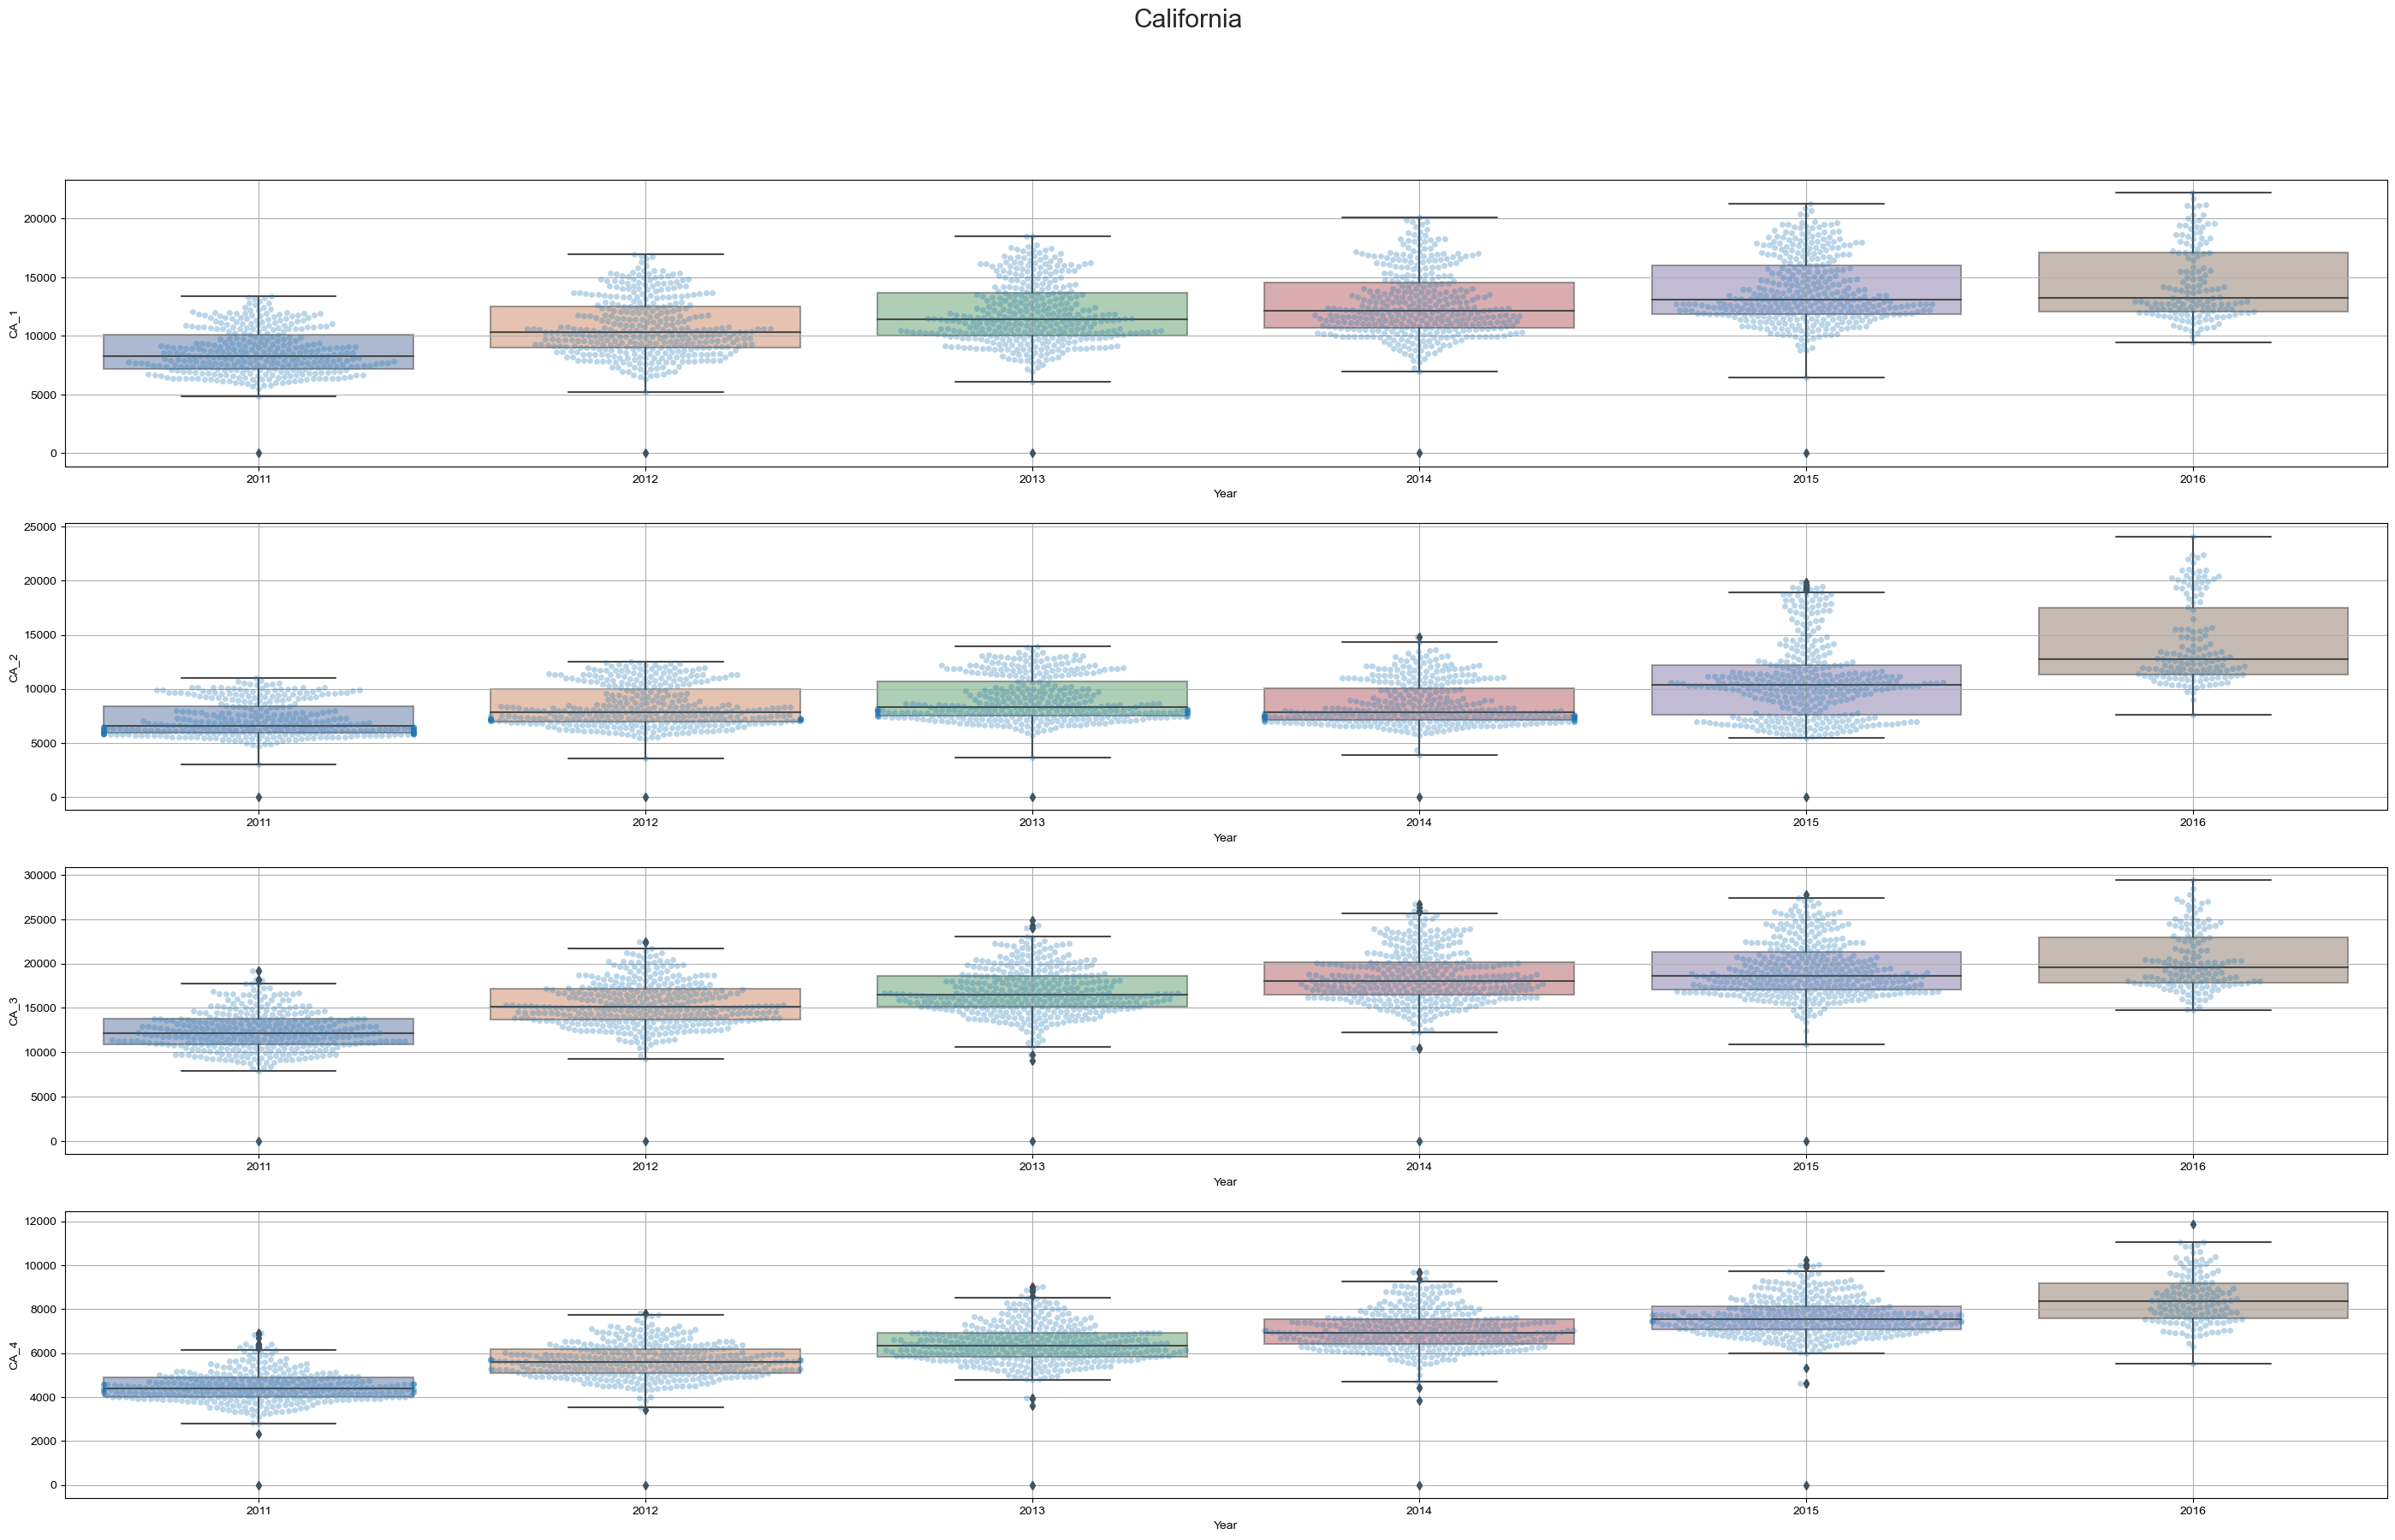

In [26]:
fig, axes = plt.subplots(figsize= (35,20), nrows=4, ncols=1)
sns.set(style='white', font_scale=1.5)
for i in range(4):    
    sns.boxplot(ax=axes[i], x=ca_store_sales_sum.index.year.tolist(),y=f'CA_{i+1}', data=ca_store_sales_sum, 
                boxprops=dict(alpha=.5));
    sns.swarmplot(y=f'CA_{i+1}', ax=axes[i], data=ca_store_sales_sum, x=ca_store_sales_sum.index.year.tolist(), 
                alpha=.3)
#     axes[i].set_title(f"California Store {i+1}")
    axes[i].set_xlabel('Year')
    axes[i].grid(True)
fig.suptitle("California")

Text(0.5, 0.98, 'Texas')

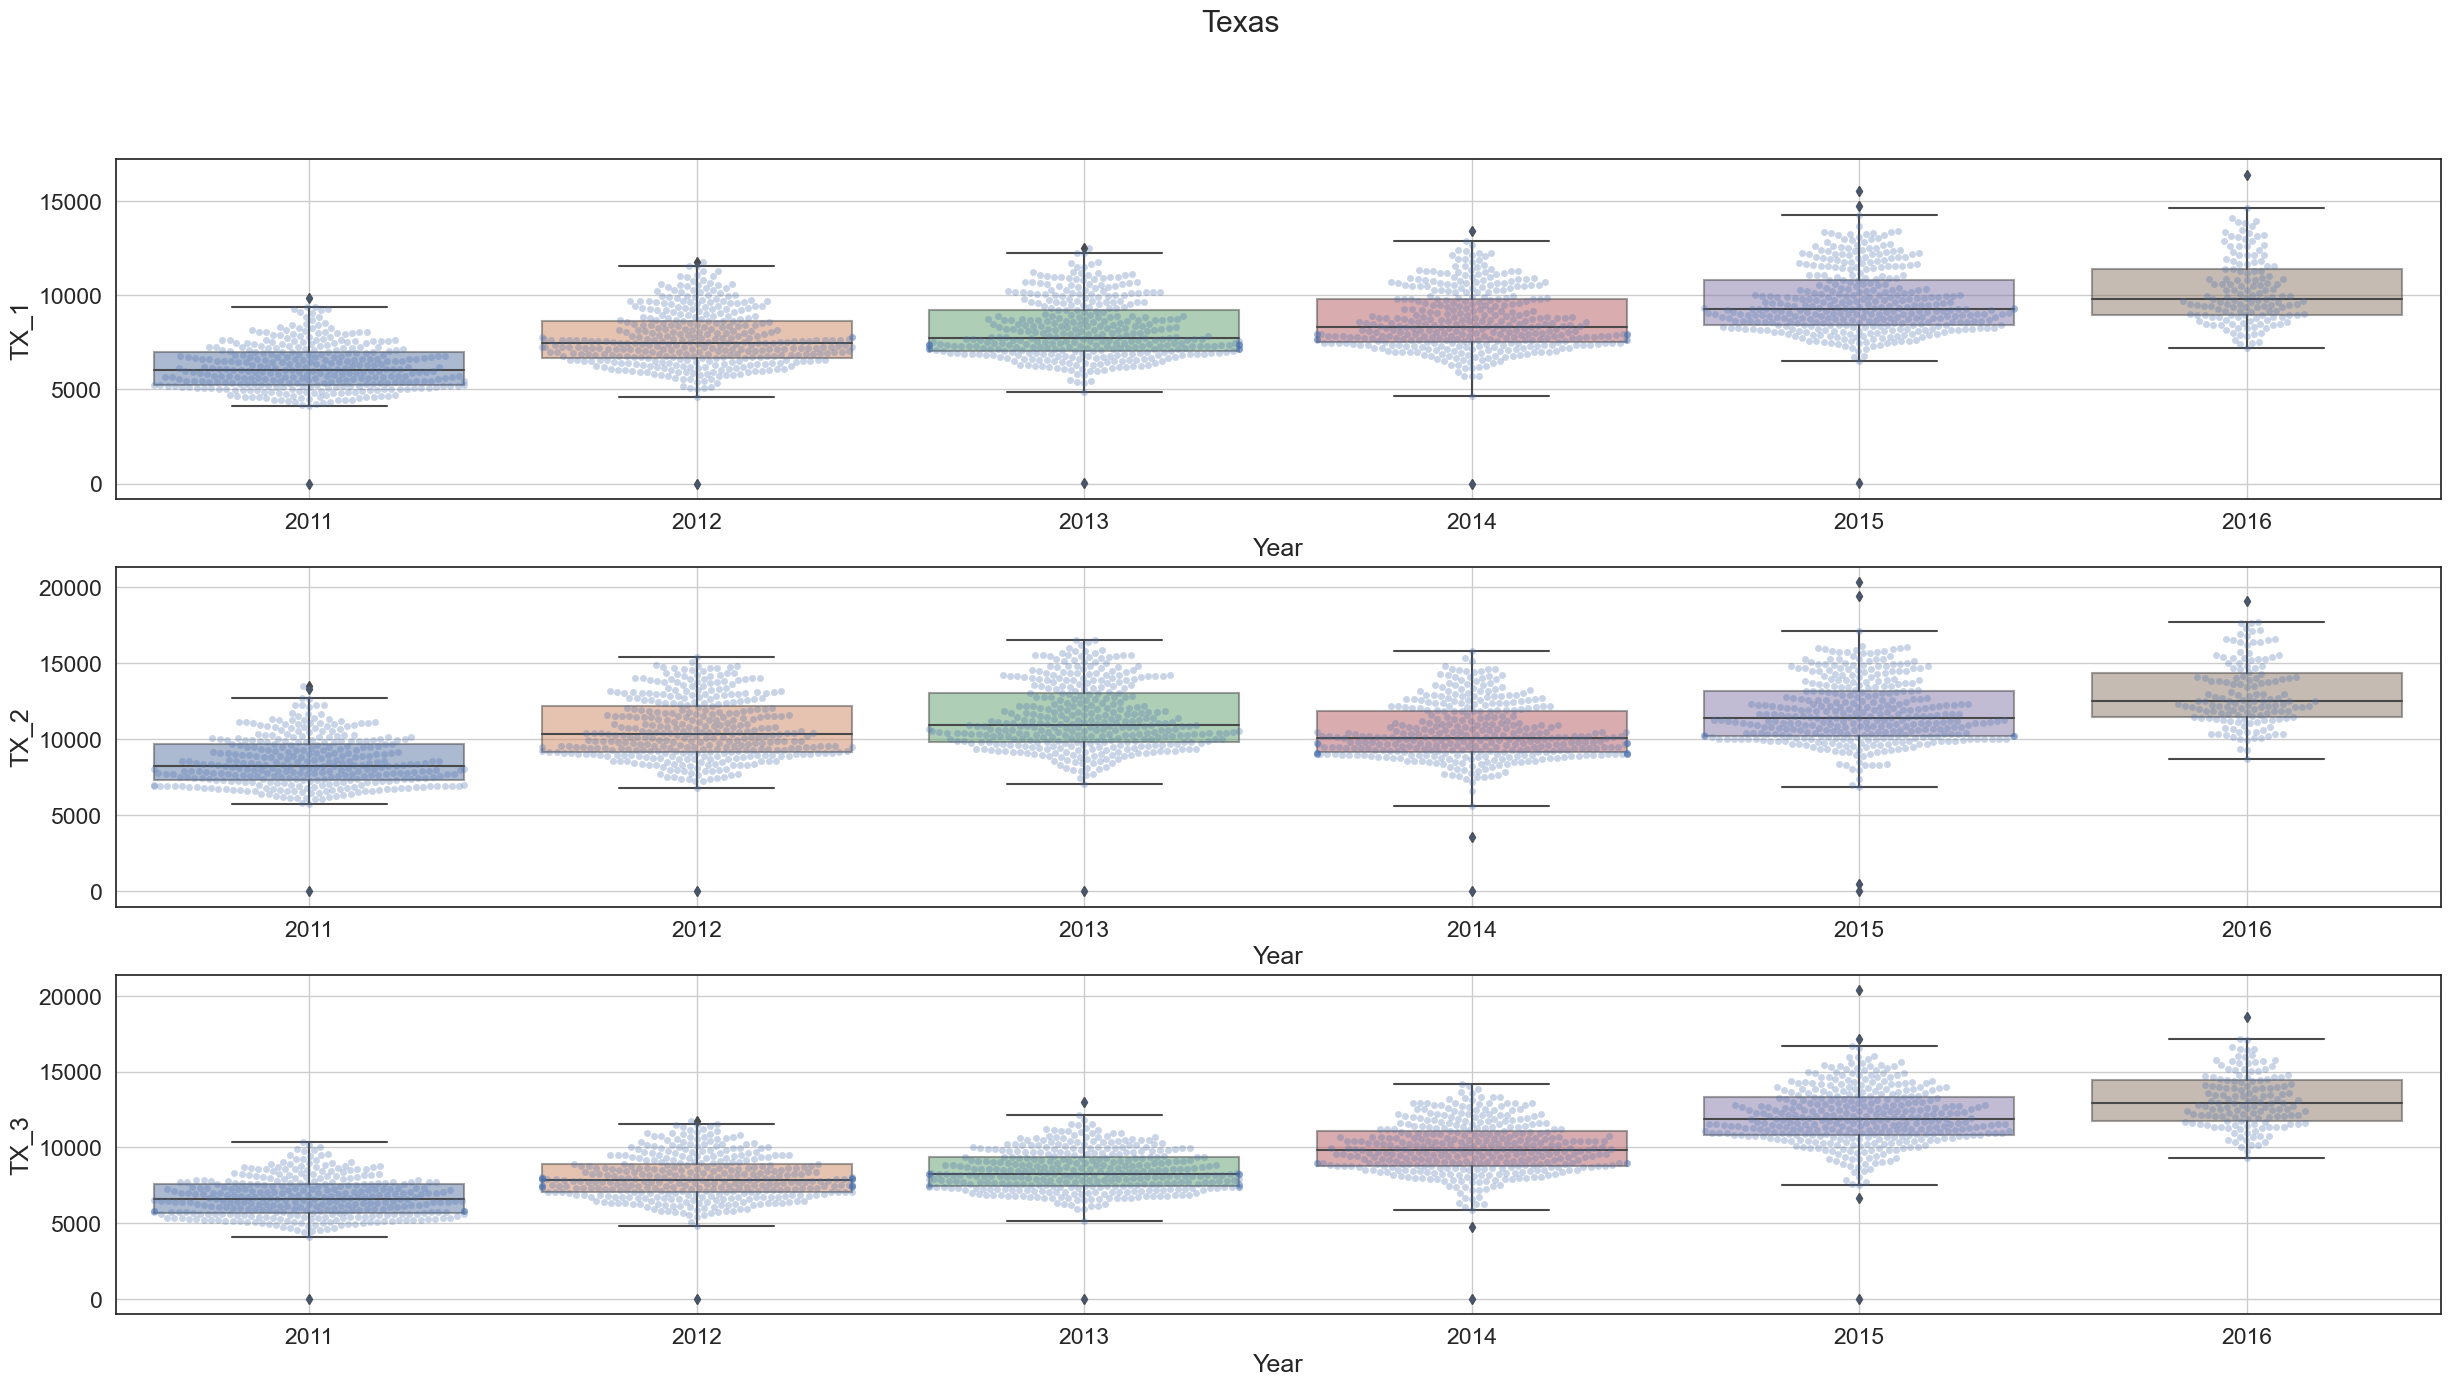

In [27]:
fig, axes = plt.subplots(figsize= (30,15), nrows=3, ncols=1)
sns.set(style='white', font_scale=1.5)
for i in range(3):    
    sns.boxplot(ax=axes[i], x=tx_store_sales_sum.index.year.tolist(),y=f'TX_{i+1}', data=tx_store_sales_sum, 
                boxprops=dict(alpha=.5));
    sns.swarmplot(y=f'TX_{i+1}', ax=axes[i], data=tx_store_sales_sum, x=tx_store_sales_sum.index.year.tolist(),
                 alpha=.3)
#     axes[i].set_title(f"Texas Store {i+1}")
    axes[i].set_xlabel('Year')
    axes[i].grid(True)
fig.suptitle("Texas")

Text(0.5, 0.98, 'Wisconsin')

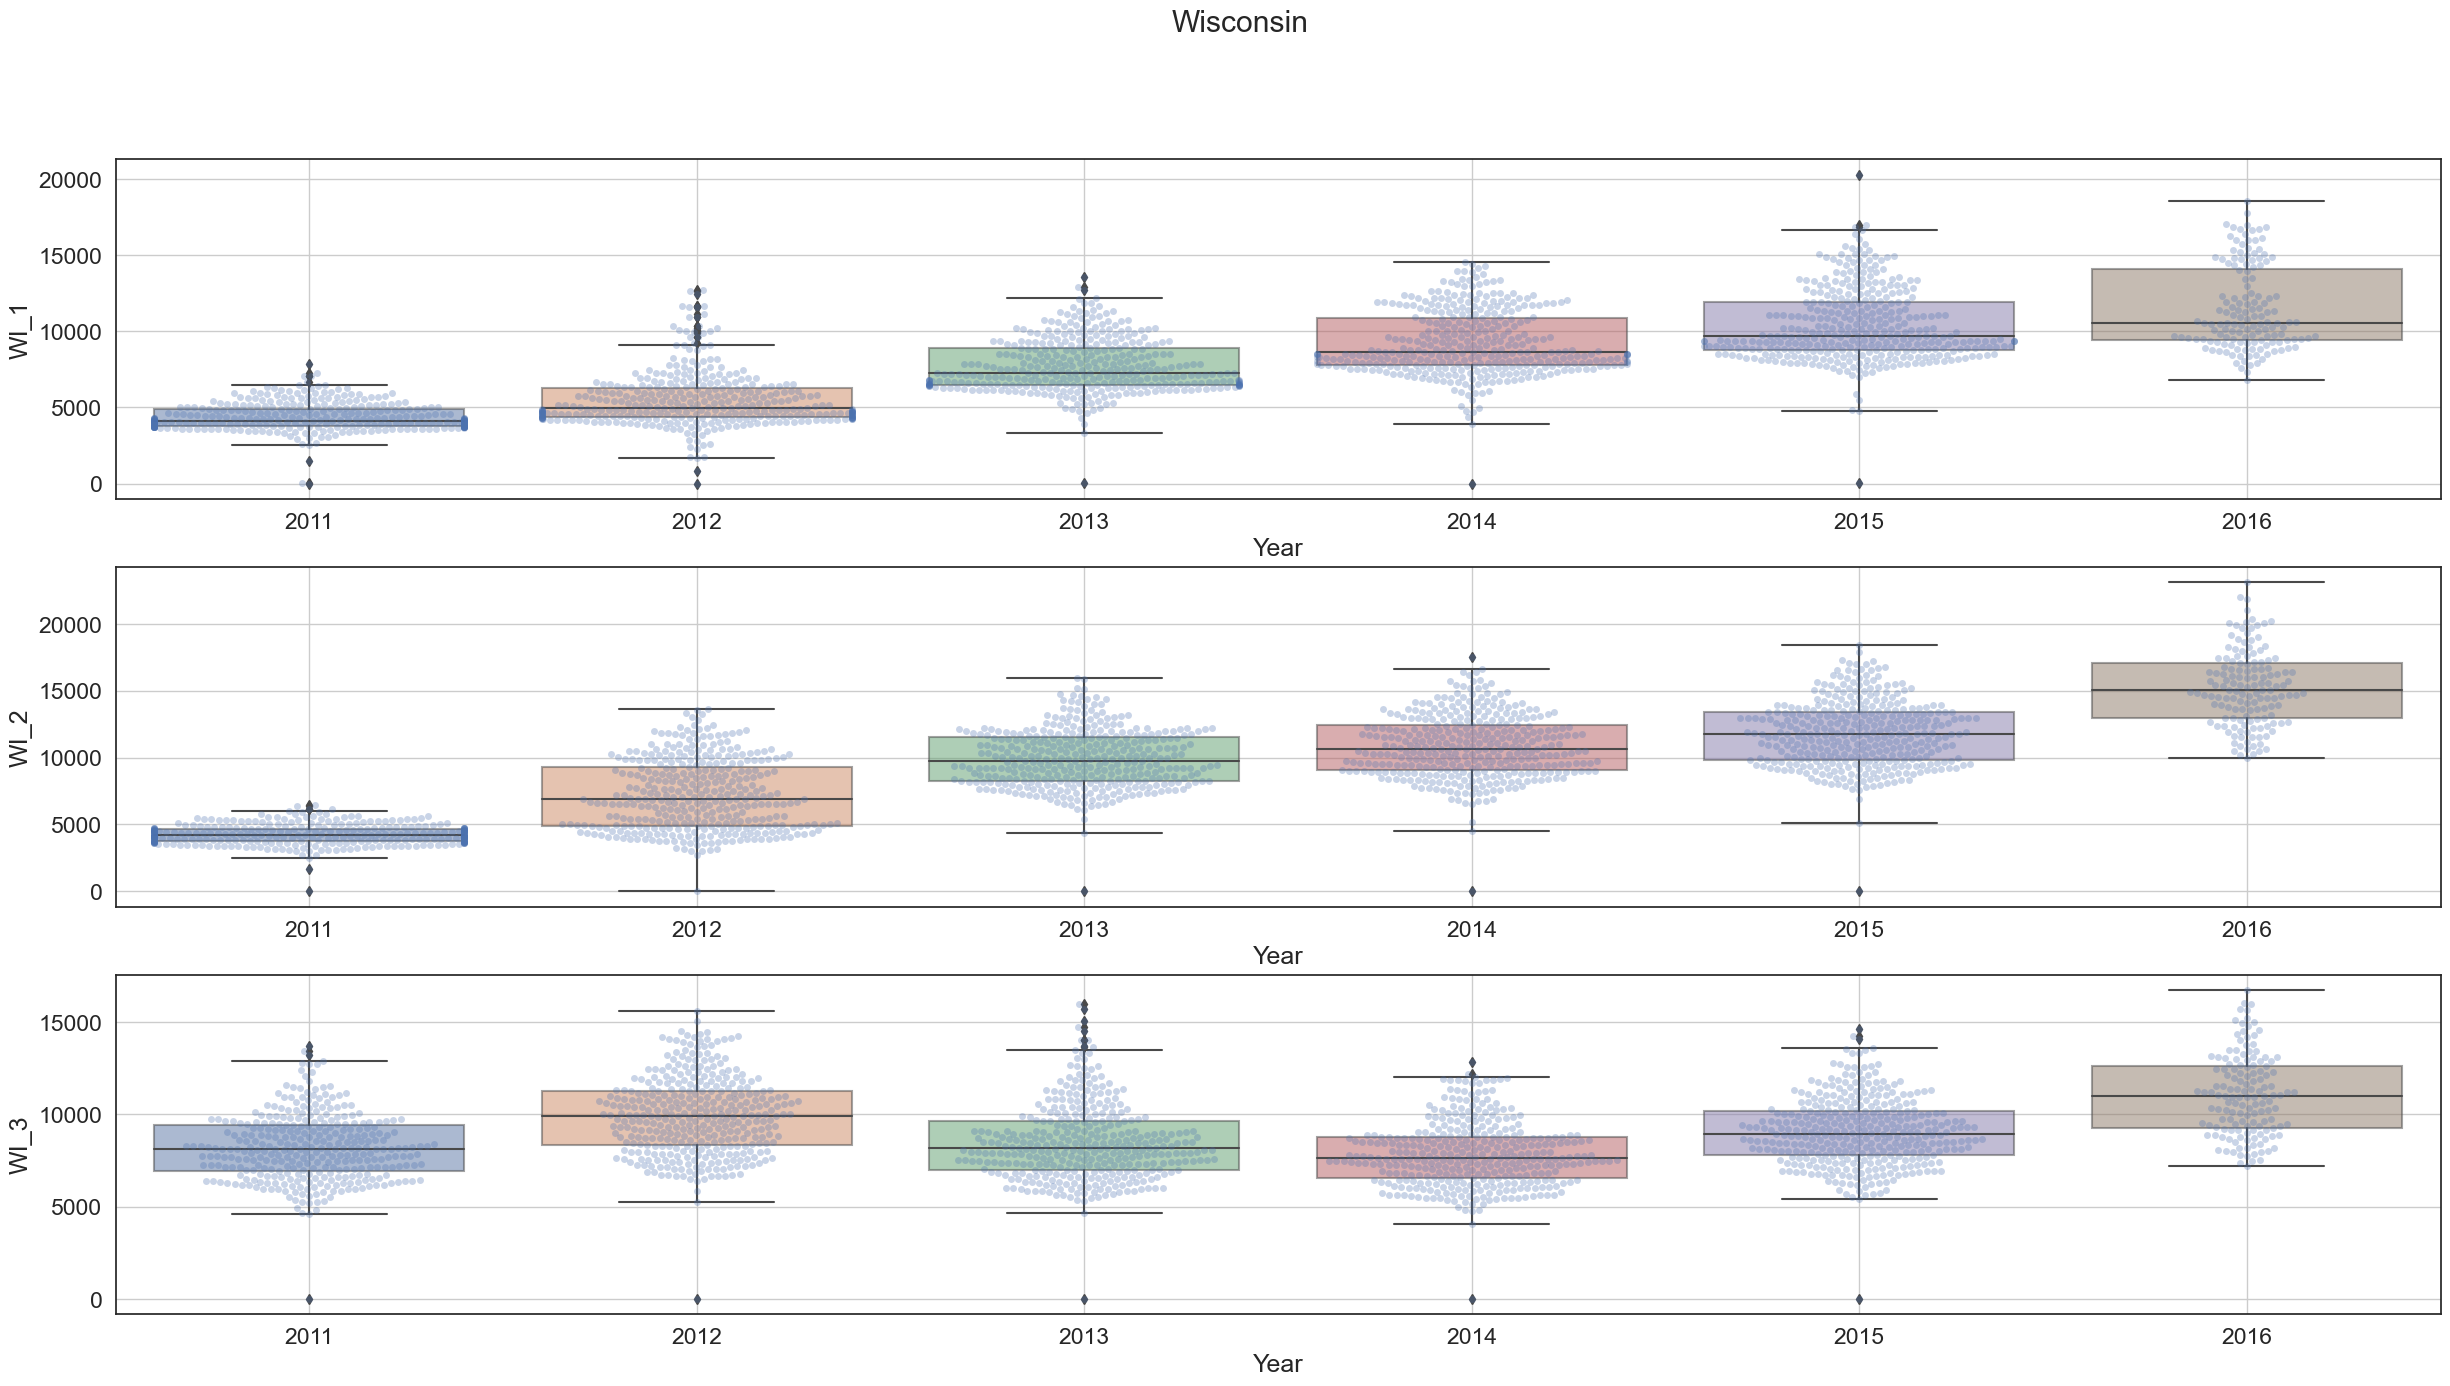

In [28]:
fig, axes = plt.subplots(figsize= (30,15), nrows=3, ncols=1)
sns.set(style='white', font_scale=1.5)
for i in range(3):    
    sns.boxplot(ax=axes[i], x=wi_store_sales_sum.index.year.tolist(),y=f'WI_{i+1}', data=wi_store_sales_sum, 
                boxprops=dict(alpha=.5));
    sns.swarmplot(y=f'WI_{i+1}', ax=axes[i], data=wi_store_sales_sum, x=wi_store_sales_sum.index.year.tolist(),
                 alpha=.3)
#     axes[i].set_title(f"Wisconsin Store {i+1}")
    axes[i].set_xlabel('Year')
    axes[i].grid(True)
fig.suptitle("Wisconsin")
# fig.tight_layout()

# Saving Data Frames

In [29]:
base_path = "Resources\\"
ca_store_sales_sum.to_csv(f"{base_path}ca_store_sales_sum.csv")
tx_store_sales_sum.to_csv(f"{base_path}tx_store_sales_sum.csv")
wi_store_sales_sum.to_csv(f"{base_path}wi_store_sales_sum.csv")